##### Copyright 2020 The Cirq Developers

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Introduction to Cirq

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/educators/intro"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/educators/intro.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/educators/intro.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/educators/intro.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

[Cirq](https://github.com/quantumlib/cirq) is a framework for writing quantum algorithms for noisy intermediate scale quantum (NISQ) devices. Roughly speaking, NISQ devices are those with O(100) qubits that can enact O(1000) gates.  Because the resources for NISQ devices are so constrained, we believe that a framework for writing programs on these devices needs to be aware of all of the architectural properties of the device on which the algorithm is written. This is in contrast to other frameworks where there is a clean separation between the abstract model being used and the details of the device.  

In this tutorial we will walk through the basics of writing quantum alogorithms in Cirq. Our final goal will be to write a variational ansatz for use in an optimization algorithm.

## Installing Cirq

To use Cirq one first needs to install Cirq.  Installation instructions are available at [quantumai.google/cirq under "Installing Cirq"](https://quantumai.google/cirq/install).  For the purpose of this tutorial, we run `pip install cirq` as shown in the following code cell to install the latest release of Cirq. 

> Different notebook execution systems exist, but for most part they have "run" button on a cell which you can click, or "shift + enter" is often the shortcut to run the cell. 

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install cirq --quiet
    print("installed cirq.")
    import cirq

import matplotlib.pyplot as plt
import numpy as np

Let's check that Cirq has been successfully installed by importing Cirq and printing out a diagram of Google's Bristlecone device shown below.

![Google's Bristecone chip](https://4.bp.blogspot.com/-b9akad6ismU/WpmyaJo-cYI/AAAAAAAACa8/mCqPBJxv5oUivy6Jq42FSOQYkeRlTmkiwCLcBGAs/s1600/image1.png)

In [3]:
"""Test successful installation by printing out the Bristlecone device."""
print(cirq.google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

This cell should run successfully, and the output should in fact be the grid of qubits for the Bristlecone device. If so, the install worked!

> Be aware that Cirq is still alpha software, meaning **breaking changes can happen at any time**. If you don't want your project to suddenly go from working to not working when we a new version is released, you should depend on a *specific version* of Cirq and periodically bump that version to the latest one. For example, you can run `pip install cirq==x.y.z` to install version `x.y.z` of Cirq.

## Qubits, Moments, Operations, and Circuits

In Cirq, circuits are represented either by a `Circuit` object. Conceptually:

- Q `Circuit` is a collection of `Moment`s. 
- A `Moment` is a collection of `Operation`s that all act during the same abstract time slice. 
- An `Operation` is a an effect that operates on a specific subset of Qubits. 
  - The most common type of `Operation` is a `Gate` applied to several qubits (a "`GateOperation`"). 
  
These ideas are illustrated by the following diagram.

![Circuits, Moments, and Operations.](/cirq/images/CircuitMomentOperation.png)

### Create a `Circuit`

A typical way to create a `Circuit` is shown below.

In [4]:
"""Creating a circuit."""
# Define three qubits.
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")

# Define a list of operations.
ops = [cirq.H(a), cirq.H(b), cirq.CNOT(b, c), cirq.H(b)]

# Create a circuit from the list of operations.
circuit = cirq.Circuit(ops)
print("Circuit:\n")
print(circuit)

Circuit:

a: ───H───────────

b: ───H───@───H───
          │
c: ───────X───────


We can unpack this a bit and see all of the components for the circuit.

The first thing we do is pick some qubits to use. There are many different types of qubits in Cirq, and you can define your own by inheriting from the `cirq.Qid` class. There's nothing inherently special or magical about these quantum id types such as `cirq.NamedQubit`. They simply identify what you wish to operate on, which is relevant when you are targeting a specific device. For example, if we were creating a circuit for the Bristlecone device and wanted to refer to the qubit in the left-most position, we would use `cirq.GridQubit(5, 0)`. (See the first diagram of the Bristlecone device we printed out.) For simplicity, in the previous cell we defined `cirq.NamedQubit`s which are simply qubits that can be identified by a name.

Next, we encounter the object `cirq.H` which is a Hadamard gate with unitary

$$
H = {1 \over \sqrt{2}} \left[ \begin{array}[cc]  & 1 & 1  \\ 1 & -1 \end{array}\right] .
$$

In Cirq, `cirq.H` is an instance of the `cirq.HGate` class, which itself is a subclass of `Gate` (along with other classes). We can use Cirq to see the unitary matrix of `Gate` objects as follows.

In [5]:
"""Get the unitary of a gate, here the Hadamard gate."""
cirq.unitary(cirq.H)

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])

We see that this agrees with the unitary for the Hadamard gate above.

`Gate` objects have the ability to applied "on" one or more qubits.  There are two ways to do this for gates, either using the `on` method or by directly calling the gate on the qubits as if the gate were a function and the qubits were arguments.  For example to apply the `H` onto qubit `a` we can say `cirq.H.on(a)` or `cirq.H(a)`.

The result of those expressions is a `GateOperation` object, which is a type of `Operation`.

> **Note**: In Cirq, there is a strong distinction between `Operation`s and `Gate`s. An `Operation` is associated with specific qubits and can be put in `Circuit`s. A `Gate` has unspecified qubits, and will produce an operation when acting on qubits.

Once you have a collection of operations, you can construct a `Circuit` by passing the operations into the constructor for a `Circuit`:

```
ops = [list of operations]
circuit = cirq.Circuit(ops)
```

The last thing we did in the example code was use the (surprisingly useful) ability to print the circuit as a text diagram.

The diagram is visually helpful, but it doesn't really get into the internal details of how the `Circuit` is represented. As mentioned, a `Circuit` is made up of a sequence of `Moment` objects, and each `Moment` object is a list of non-overlapping `Operation`s. To see this internal structure, we can iterate over the `Moment`s in the `Circuit` and print them out.

In [6]:
"""Print out the moments in a circuit."""
print("Circuit:\n")
print(circuit)

print("\nMoments in the circuit:\n")
for i, moment in enumerate(circuit):
    print('Moment {}: {}'.format(i, moment))

Circuit:

a: ───H───────────

b: ───H───@───H───
          │
c: ───────X───────

Moments in the circuit:

Moment 0: H(a) and H(b)
Moment 1: CNOT(b, c)
Moment 2: H(b)


We see that this circuit consists of three moments. For even more on the underlying structure of a circuit, we can print the circuit's `repr`. This returns a more detailed (and usually less readable) expression.

In [7]:
"""Print the repr of a circuit."""
print(repr(circuit))

cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.NamedQubit('a')),
        cirq.H(cirq.NamedQubit('b')),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.NamedQubit('b'), cirq.NamedQubit('c')),
    ),
    cirq.Moment(
        cirq.H(cirq.NamedQubit('b')),
    ),
])


Although it is less readable, the usefulness of printing the `repr` is that it includes *all* the gory details which can be useful when debugging. The `repr` is also a valid python expression that evaluates to the circuit.
For example, if we notice that a circuit generated in some complicated way triggers a bug in a simulator, copy-pasting the generated circuit's `repr` into a test, and then working from there, is a simple way to decouple the reproduction of the bug from the circuit generation code.

### More ways to create `Circuit`s

Above we created a `Circuit` by passing in a list of operations to its constructor.  In Cirq, there are many ways to construct and modify circuits, and each of these is useful in different contexts.  Here are a few examples:


1. `Circuit(...)`: This is the simplest way to make a circuit. Give this method some operations, and out pops a circuit.
2.  `append`:  `Circuit`s are mutable. You can start with an empty `circ = cirq.Circuit()` and simply `circ.append(operations)` to add on more and more operations .
3. `insert`:  Instead of appending, you can insert before a particular moment location (labeled by an integer index).

One interesting, and extremely convenient, fact about `Circuit(...)`, `append`, and `insert` is that they "auto flatten" whatever you give them.
You *can* give them a list of operations, but you can also give them

- a list *of lists* of operations,
- a generator function that sometimes yields tuples of operations and other times yields individual operations,
- or just a single operation (without a list around it).

If it can recursively iterated into individual operations, these three methods will take it.

> The above idea uses a concept we call an `OP_TREE` in Cirq. An `OP_TREE` is not a class, but a contract. The basic idea is that if the input can be iteratively flattened into a list of operations, then the input is an `OP_TREE`.

The main place where auto-flattening is useful is when you are building a circuit's operations using generators. 

> Recall that, in Python, functions that have a `yield` statement are *generators*. Generators are functions that act as *iterators*. 

In this context, auto-flattening means that generators producing operations for a circuit can simply `yield` sub-generators (instead of iterating over them and yielding their items). We show an example of this below.

In [8]:
"""Creating a circuit from generator functions."""
def xor_swap(a, b):
    """Swaps two qubits with three CNOTs."""
    yield cirq.CNOT(a, b)
    yield cirq.CNOT(b, a)
    yield cirq.CNOT(a, b)


def left_rotate(qubits):
    """Rotates qubits to the left."""
    for i in range(len(qubits) - 1):
        a, b = qubits[i: i + 2]
        yield xor_swap(a, b)


# Get five qubits on a line.
line = cirq.LineQubit.range(5)

# Create a circuit which rotates the qubits to the left.
print(cirq.Circuit(left_rotate(line)))

0: ───@───X───@───────────────────────────────────────
      │   │   │
1: ───X───@───X───@───X───@───────────────────────────
                  │   │   │
2: ───────────────X───@───X───@───X───@───────────────
                              │   │   │
3: ───────────────────────────X───@───X───@───X───@───
                                          │   │   │
4: ───────────────────────────────────────X───@───X───


One can see how this method of creating circuits is quite powerful. 

> Note that `cirq.SWAP` is a pre-defined gate in Cirq. We used three `cirq.CNOT`s instead of `cirq.SWAP` in the above example to demonstrate auto-flattening with generators.

### Insert strategies

You may have noticed that there is a hole in what we've explained so far. We have been passing a one-dimensional sequence of operations, but the output is a two-dimensional circuit (a list-of-lists-of-operations). There is a degree of freedom that hasn't been account for. Specifically, how does Cirq choose the moment that each operation will be placed within?

The answer is the concept of a `cirq.InsertStrategy`. An `InsertStrategy` defines how `Operation`s are placed in a `Circuit` when requested to be inserted at a given location. Here a `location` is identified by the index of the `Moment` in the `Circuit` that operations should be placed before. 

> *Note*: In the case of `Circuit.append` this means inserting at the index `len(circuit)` which is one more than the largest moment index and so represents the end of the circuit.

There are currently four insertion strategies in Cirq:

1. `InsertStrategy.EARLIEST` (currently the default),
2. `InsertStrategy.NEW`,
3. `InsertStrategy.INLINE`,
4. `InsertStrategy.NEW_THEN_INLINE`.

The strategy `InsertStrategy.EARLIEST` is defined as follows:

> `InsertStrategy.EARLIEST`: Scans backward from the insert
> location until a moment with operations touching qubits affected by the
> operation to insert is found. The operation is added into the moment just
> after that location.

For example, if we first create an `Operation` in a single moment,
and then use `InsertStrategy.EARLIEST` the `Operation` can slide back to this
first `Moment` if there is space.

In [9]:
"""Appending operations with InsertStrategy.EARLIEST."""
# Create an empty circuit.
circuit = cirq.Circuit()

# Append an operation.
# Note: InsertStrategy.EARLIEST is used by default if not otherwise specified.
circuit.append([cirq.CZ(a, b)])

# Append more operations.
# Note: InsertStrategy.EARLIEST is used by default if not otherwise specified.
circuit.append([cirq.H(a), cirq.H(b), cirq.H(c)])

# Display the circuit.
print("Circuit:\n")
print(circuit)

Circuit:

a: ───@───H───
      │
b: ───@───H───

c: ───H───────


After creating the first moment with a `CZ` gate, the second
append uses the `InsertStrategy.EARLIEST` strategy. The
`H` on ``a`` and ``b`` cannot slide back, while the `H` on ``c`` can and so ends up in the first `Moment`.

While `InsertStrategy.EARLIEST` is the default strategy, the second most important strategy is `InsertStrategy.NEW_THEN_INLINE`, defined as follows:

> `InsertStrategy.NEW_THEN_INLINE`: For the first operation, add it to a new 
> `Moment` the insertion point.  Attempts to add the operation after the first 
> operation to insert into the moment just before the desired insert location. 
> But, if there's already an existing operation affecting any of the qubits
> touched by the operation to insert, a new moment is created instead and this 
> `Moment` is the one that is subsequently used for insertions.

To see an example of this strategy, we create a circuit with the same operations but inserting them with a different strategy.

In [10]:
"""Appending operations with InsertStrategy.NEW_THEN_INLINE."""
# Create an empty circuit.
circuit = cirq.Circuit()

# Append an operation.
circuit.append([cirq.CZ(a, b)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Append more operations.
circuit.append([cirq.H(a), cirq.H(b), cirq.H(c)], strategy=cirq.InsertStrategy.NEW_THEN_INLINE)

# Display the circuit.
print("Circuit:\n")
print(circuit)

Circuit:

a: ───@───H───
      │
b: ───@───H───

c: ───────H───


In contrast to the previous codeblock using `InsertStrategy.EARLIEST`, we see that the three `cirq.H` gates appended after the `cirq.CZ` gate appear in the same moment when we use `InsertStrategy.NEW_THEN_INLINE`.

### Exercise: Create a circuit

Now that you've learned about `InsertStrategy`s, here is an exercise to validate your understanding.  Create, **using the least number of appends**, the following circuit:



```
a: ───@───H───────────H───H───
      │
b: ───@───────H───@───H───────
                  │
c: ───H───────────@───────────
```

Here imagine that you want exactly the moments indicated by the spacing of the circuit so that there are six moments in this circuit.

#### Solution

In [11]:
#@title
# Define three qubits.
a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')
c = cirq.NamedQubit('c')

# Get an empty circuit.
circuit = cirq.Circuit()

# Append these gates using cirq.InsertStrategy.EARLIEST (the default strategy).
circuit.append([cirq.CZ(a, b), cirq.H(c), cirq.H(a)])

# Append these gates using cirq.InsertStrategy.NEW_THEN_INLINE.
circuit.append(
    [cirq.H(b), cirq.CZ(b, c), cirq.H(b), cirq.H(a), cirq.H(a)],
    strategy=cirq.InsertStrategy.NEW_THEN_INLINE
)

# Display the circuit.
print("Circuit:\n")
print(circuit)

Circuit:

a: ───@───H───────────H───H───
      │
b: ───@───────H───@───H───────
                  │
c: ───H───────────@───────────


## Simulations of a Circuit

Now that we know how to construct `Circuit`s in Cirq, let's see how to simulate them. First we create a simple circuit to simulate in the following cell.

In [12]:
"""Get a circuit to simulate."""
def basic_circuit(measure=True):
    """Returns a simple circuit with some one- and two-qubit gates,
    as well as (optionally) measurements.
    """
    # Gates we will use in the circuit.
    sqrt_x = cirq.X**0.5
    cz = cirq.CZ
    
    # Yield the operations.
    yield sqrt_x(a), sqrt_x(b)
    yield cz(a, b)
    yield sqrt_x(a), sqrt_x(b)
    if measure:
        yield cirq.measure(a,b)

# Create a circuit including measurements.
circuit = cirq.Circuit(basic_circuit())
print(circuit)

a: ───X^0.5───@───X^0.5───M───
              │           │
b: ───X^0.5───@───X^0.5───M───


The main simulator in Cirq is the `cirq.Simulator`. The general pattern of simulation is to instantiate this simulator, then pass in a circuit to either the `run` or `simulate` methods (more on this below).

In [13]:
"""Example of simulating a circuit in Cirq."""
# Get a simulator.
simulator = cirq.Simulator()

# Pass the circuit to the simulator.run method.
result = simulator.run(circuit, repetitions=1)
print("Measurement results:")
print(result)

Measurement results:
a,b=0, 1


Running this multiple times should result in different measurement results, since the circuit produces a superposition over all computational basis states.

Above we used the `run` method of the `simulator`. In Cirq, `run` methods mimic the actual hardware in that they don't give one access to unphysical objects like the wavefunction. The `repetitions` argument is how many times to sample from the circuit.

If one wants to get the wavefunction, the `simulate` methods can be used as shown below.

In [14]:
"""Simulating a circuit with the `simulate` method."""
# Get a circuit without measurements.
circuit = cirq.Circuit(basic_circuit(measure=False))

# Simulate the circuit.
result = simulator.simulate(circuit, qubit_order=[a, b])

# Print the final state vector (wavefunction).
print("Wavefunction:")
print(np.around(result.final_state_vector, 3))

# Print the wavefunction in Dirac notation.
print("\nDirac notation:")
print(result.dirac_notation())

Wavefunction:
[0.5+0.j  0. +0.5j 0. +0.5j 0.5+0.j ]

Dirac notation:
0.5|00⟩ + 0.5j|01⟩ + 0.5j|10⟩ + 0.5|11⟩


Notice that we passed a `qubit_order` into the `simulate` method.  This order helps define the order of the kronecker (tensor) product used in the resulting `final_state_vector`.  

> *Note*: The `qubit_order` argument is optional. When it is omitted, qubits are sorted ascending according to the ordering methods defined by their Python class (for example `cirq.NamedQubit` sorts lexicographically by name).
If there are multiple types of qubits in one circuit, the name of the type is used as a tie breaker.

The simplest `qubit_order` value you can provide is a list of the qubits in the desired order. Any qubits from the circuit that are not in the list will be ordered using the  default `__str__` ordering, but come after qubits that are in the list. 

> **Note**: Be aware that all qubits in the list are included in the simulation, even if they are not operated on by the circuit.

The mapping from the order of the qubits to the order of the  amplitudes in the wave function can be tricky to understand.  Basically, it is the same as the ordering used by `numpy.kron`.

> If the wavefunction is the array 
>> (0.1, 0.2, 0.3, 0.4),

> then this is 
>> 0.1|00⟩ + 0.2|01⟩ + 0.3|10⟩ + 0.4|11⟩ 

> in Dirac notation. If 
>> qubit order = [a, b]

> then |00> means qubit a is in 0 and qubit b is in 0, |01> means 
> qubit a is 0 and qubit b is 1, etc.

Another way to think about the qubit-to-amplitude ordering is as "for loop ordering":

```
for a in [0, 1]:
    for b in [0, 1]:
        print(a, b)
```

The first index (the outermost loop) is the slowest to vary.

### Repetitions and histograms

As mentioned, the simulator `run` methods also take an option for repeating the circuit, namely, the `repetitions` argument. If the measurements in the circuit are terminal and all other operations are unitary, this simulator is optimized to not recompute the wavefunction before sampling from the circuit.

In [15]:
"""Simulate a circuit using 1000 repetitions."""
# Get a circuit with terminal measurements to simulate.
circuit = cirq.Circuit(basic_circuit())

# Sample from the circuit 1000 times.
result = simulator.run(circuit, repetitions=1000)

# Get a histogram of measurement results.
print(result.histogram(key="a,b"))

Counter({1: 261, 3: 256, 2: 248, 0: 235})


Here we have also demonstrated the use of the `histogram` method on the `result` which sums over all the different results for all of the different repetitions.

The `histogram` method can also be given a `fold_func` argument, in order to group measurement results under some key before counting them up.
For example, we can group by whether or not the two measurement results agreed:

In [16]:
print(result.histogram(key="a,b", fold_func=lambda bits: "agree" if bits[0] == bits[1] else "disagree"))

Counter({'disagree': 509, 'agree': 491})


## The Deutsch-Jozsa Algorithm

The very first indication that quantum computers could be more powerful than classical computers was provided by David Deutsch in his 1985 paper

> David Deutsch,  "[Quantum Theory, the Church-Turing Principle and the Universal Quantum Computer](https://people.eecs.berkeley.edu/~christos/classics/Deutsch_quantum_theory.pdf)" *Proc. R. Soc. Lond.* A **400** 97–117. http://doi.org/10.1098/rspa.1985.0070

This algorithm was extended by Deutsch and Richard Jozsa to a more convincing algorithmic seperation and what is now called the Deutsch-Jozsa algorithm.  In this section we will show how to write circuits for the Deutsch algorithm and then as an exercise in using Cirq for algorithms for a small version of the Deutsch-Jozsa algorithm.

Let's begin with the Deutsch algorithm.  In Deutsch's algorithm you are given access to a box which computes a one bit boolean function.  That is it is a box which takes in a bit and outputs a bit.  If we want to be a mathematician or theoretical computer scientist we write the function $f$ as $f: \{0, 1\} \rightarrow \{0, 1\}$.  There are exactly four such boolean functions which we can write out in a table

| $x$ | $f_0$ | $f_1$ | $f_x$ | $f_{\bar{x}}$ |
| --- |  --- | --- | --- | --- |
| 0 | 0 | 1 | 0 | 1
| 1 | 0 | 1 | 1 | 0

The first two of these are *constant* functions, $f_0$ and $f_1$.  That is they always output a constant value (independent of the input).  The other two $f_x$ and $f_\bar{x}$ are *balanced*.  Over their inputs $0$ and $1$, they have an equal number of $0$s and $1$s in their truth table.  

We can now state Deutsch's problem:

> Given access to a one bit input one bit output boolean function, determine by querying the function whether the function is *balanced* or *constant*.

It shouldn't take you much to convince yourself that in order to solve this problem classically you need to call the function on both possible input values.  The easiest way to see this is just to consider what happens if you query the function on one particular input and notice that, for either input, learning the value of the function does not separate the constant from balanced functions. In summary:

*Classically one must query the binary function twice to distinguish the constant function from the balanced function.*

Now lets turn to the quantum approach to this problem.  There is one bit of book keeping we need to take care of.  Above we have described a classical function on bits that is not reversible.  That is, knowing the values of the output does not allow us to determine uniquely the value of the input.  In order to run this on a quantum computer, however we need to make this computation reversible.  A trick for taking a classical non-reversible function and making it "quantum happy" is to compute the value in an extra register and store the input.  Suppose we have an $n$ bit input $x$ and we are computing a (potentially non-reverisble) boolean function $f(x)$.  Then we can implement this via a Unitary $U_f$ that acts like on $n + 1$ qubits

$$
U_f |x\rangle |y\rangle = |x\rangle | y \oplus f(x)\rangle .
$$

Here $\oplus$ is addition modulo $2$ (XOR) and we have identified how $U_f$ acts by its action on all computational basis states $|x\rangle$ ($n$ input qubits) and $|y\rangle$ ($1$ output qubit). To see that this is reversible one can note that applying the transformation twice returns the state to its original form.

Let's see how to implement these functions in Cirq.

$f_0$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |00\rangle \\
|01\rangle &\rightarrow&  |01\rangle \\
|10\rangle &\rightarrow&  |10\rangle \\
|11\rangle &\rightarrow&  |11\rangle \\
\end{eqnarray}
$$
Well this is just the identity transform, i.e. an empty circuit.

$f_1$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |01\rangle \\
|01\rangle &\rightarrow&  |00\rangle \\
|10\rangle &\rightarrow&  |11\rangle \\
|11\rangle &\rightarrow&  |10\rangle \\
\end{eqnarray}
$$
This is the `cirq.X` bit flip gate on the second qubit.

$f_x$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |00\rangle \\
|01\rangle &\rightarrow&  |01\rangle \\
|10\rangle &\rightarrow&  |11\rangle \\
|11\rangle &\rightarrow&  |10\rangle \\
\end{eqnarray}
$$
This is nothing more than a `cirq.CNOT` from the first bit to the second bit.

Finally $f_\bar{x}$ enacts the transform
$$
\begin{eqnarray}
|00\rangle &\rightarrow&  |01\rangle \\
|01\rangle &\rightarrow&  |00\rangle \\
|10\rangle &\rightarrow&  |10\rangle \\
|11\rangle &\rightarrow&  |11\rangle \\
\end{eqnarray}
$$
which is a `cirq.CNOT` from the first bit to the second bit followed by a `cirq.X` on the second bit.

We can encapulate these functions into a dictionary from a oracle name to the operations in the circuit needed to enact this function.

In [17]:
"""Store the operations to query each function in a dictionary."""
# Get qubits for the operations to act on.
q0, q1 = cirq.LineQubit.range(2)

# Define the dictionary of operations. The key of each dictionary entry
# is the subscript of the function f in the above explanatory text.
oracles = {
    '0': [],
    '1': [cirq.X(q1)],
    'x': [cirq.CNOT(q0, q1)],
    'notx': [cirq.CNOT(q0, q1), cirq.X(q1)]
}    

We now turn to Deutch's algorithm.  Suppose we are given access to the reversible oracle functions we have defined above.  By a similar argument for our irreversible classical functions you can show that you cannot distinguish the balanced from the constant functions by using this oracle only once.  But now we can ask the question: what if we are allowed to query this box in superposition, i.e. what if we can use the power of quantum computing?

Deutsch was able to show that you could solve this problem now, with quantum computers, using only a single query.  To see how this works we need two simple insights.

Suppose that we prepare the second qubit in the superposition state $|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ and apply the oracle.  Then we can check that
$$ 
U_f |x\rangle |-\rangle = U_f|x\rangle \frac{1}{\sqrt{2}}(|0\rangle -|1\rangle ) = |x\rangle \frac{1}{\sqrt{2}}(|f(x)\rangle -|f(x) \oplus 1\rangle ) =  (-1)^{f(x)} |x\rangle |-\rangle .
$$  
This is the so called "phase kickback trick".  By applying $U_f$ onto a target which is in superposition, the value of the function ends up showing up in the global phase.  

How can we leverage this to distinguish between the constant and balanced functions?  Note that for the constant functions the phase that is applied is the same for all inputs $|x\rangle$, whereas for the balanced functions the phase is different for each value of $x$.  In other words, if we use the phase kickback trick then for each of the oracles we apply the following transform on the first qubit:

$$
\begin{eqnarray}
f_0 \rightarrow I, &&
f_1 \rightarrow -I, &&
f_x \rightarrow Z, &&
f_\bar{x} \rightarrow -Z &&
\end{eqnarray}
$$

Now we only need, on the first qubit, to distinguish between the identity gate and the $Z$ gate.  But we can do this by recalling the identity

$$ 
H Z H = X
$$

where $H$ is the Hamadard gate.

This means that we can turn a phase flip into a bit flip by applying Hadamards before and after the phase flip.  If we look at the constant and balanced functions we see that this means that the constant functions will be proportional to $I$ and the balanced functions will be proportional to $X$.  If we feed in $|0\rangle$ to this register, then in the first cases we will only see $|0\rangle$ and in the second case we will only see $|1\rangle$.  In other words we will be able to distinguish constant from balanced using a single query of the oracle.

Let's code this up.

In [18]:
"""Creating the circuit used in Deutsch's algorithm."""
def deutsch_algorithm(oracle):
    """Returns the circuit for Deutsch's algorithm given an input
    oracle, i.e., a sequence of operations to query a particular function.
    """
    yield cirq.X(q1)
    yield cirq.H(q0), cirq.H(q1)
    yield oracle
    yield cirq.H(q0)
    yield cirq.measure(q0)

for key, oracle in oracles.items():
    print(f"Circuit for f_{key}:")
    print(cirq.Circuit(deutsch_algorithm(oracle)), end="\n\n")

Circuit for f_0:
0: ───H───H───M───

1: ───X───H───────

Circuit for f_1:
0: ───H───H───M───

1: ───X───H───X───

Circuit for f_x:
0: ───H───────@───H───M───
              │
1: ───X───H───X───────────

Circuit for f_notx:
0: ───H───────@───H───M───
              │
1: ───X───H───X───X───────



Lets run these circuits a bunch of times to see that the measurement result ends up correctly distinguishing constant from balanced.

In [19]:
"""Simulate each of the circuits."""
simulator = cirq.Simulator()
for key, oracle in oracles.items():
    result = simulator.run(cirq.Circuit(deutsch_algorithm(oracle)), 
                          repetitions=10)
    print('oracle: f_{:<4} results: {}'.format(key, result))

oracle: f_0    results: 0=0000000000
oracle: f_1    results: 0=0000000000
oracle: f_x    results: 0=1111111111
oracle: f_notx results: 0=1111111111


We interpret the simulation results as follows:

- For the first two functions $f_0$ and $f_1$, we always measure $0$. Therefore, we know that these functions are constant.
- For the second two functions $f_x$ and $f_{\bar{x}}$, we always measure $1$. Therefore, we know that these functions are balanced.

### Exercise: Two Bit Deutsch-Jozsa Algorithm

All boolean functions for one input bit are either constant or balanced.  For boolean functions from two input bits not all functions are constant or balanced.  There are two constant functions, $f(x_0, x_1) = 0$ and $f(x_0, x_1)=1$, while there are ${4 \choose 2} = 6$ balanced functions.  The following code gives you the operations for these functions where we take two input qubits and compute the function in the third qubit.

In [20]:
"""Operations to query all possible functions on two bits.
Two of these functions are constant, and six of these functions are balanced.
"""
# Define three qubits to use.
q0, q1, q2 = cirq.LineQubit.range(3)

# Define the operations to query each of the two constant functions.
constant = (
    [], 
    [cirq.X(q2)]
)

# Define the operations to query each of the six balanced functions.
balanced = (
    [cirq.CNOT(q0, q2)], 
    [cirq.CNOT(q1, q2)], 
    [cirq.CNOT(q0, q2), cirq.CNOT(q1, q2)],
    [cirq.CNOT(q0, q2), cirq.X(q2)], 
    [cirq.CNOT(q1, q2), cirq.X(q2)], 
    [cirq.CNOT(q0, q2), cirq.CNOT(q1, q2), cirq.X(q2)]
)

An extension of Deutsch's orginal algorithm is the Deutsch-Jozsa algorithm, which can distinguish constant from balanced functions like these using a single query to the oracle.  **The goal of this exercise** is to write a quantum circuit that can distinguish these.

In [21]:
"""Exercise: Write a quantum circuit that can distinguish 
constant from balanced functions on two bits.
"""
def your_circuit(oracle):
    # Your code here!
    yield oracle
    # Your code here!
    yield cirq.measure(q2)

You can check your circuit by running the follow cell which simulates the circuit for all oracles.

In [22]:
"""Check your answer by running this cell."""
simulator = cirq.Simulator()
    
print("\nYour result on constant functions:")
for oracle in constant:
    result = simulator.run(cirq.Circuit(your_circuit(oracle)), repetitions=10)
    print(result)
    
print("\nYour result on balanced functions:")
for oracle in balanced:
    result = simulator.run(cirq.Circuit(your_circuit(oracle)), repetitions=10)
    print(result)


Your result on constant functions:
2=0000000000
2=1111111111

Your result on balanced functions:
2=0000000000
2=0000000000
2=0000000000
2=1111111111
2=1111111111
2=1111111111


#### Solution

In [23]:
#@title
def dj_circuit(oracle):
    # Phase kickback trick.
    yield cirq.X(q2), cirq.H(q2)
    
    # Get an equal superposition over input bits.
    yield cirq.H(q0), cirq.H(q1)
    
    # Query the function.
    yield oracle
    
    # Use interference to get result, put last qubit into |1>.
    yield cirq.H(q0), cirq.H(q1), cirq.H(q2)
    
    # Use a final OR gate to put result in final qubit.
    yield cirq.X(q0), cirq.X(q1), cirq.CCX(q0, q1, q2)
    yield cirq.measure(q2)

As above, we can check the solution by running the circuit with each of the oracles.

In [24]:
"""Simulate the Deutsch-Jozsa circuit and check the results."""
print("Result on constant functions:")
for oracle in constant:
    result = simulator.run(cirq.Circuit(dj_circuit(oracle)), repetitions=10)
    print(result)
    
print("\nResult on balanced functions:")
for oracle in balanced:
    result = simulator.run(cirq.Circuit(dj_circuit(oracle)), repetitions=10)
    print(result)

Result on constant functions:
2=0000000000
2=0000000000

Result on balanced functions:
2=1111111111
2=1111111111
2=1111111111
2=1111111111
2=1111111111
2=1111111111


As with the single-bit case (Deutsch's algorithm), we always measure $0$ for constant functions and always measure $1$ for balanced functions.

## Gates

Cirq comes with a plethora of common gates.  Here we show a few of them.

In [25]:
"""Examples of common gates defined in Cirq."""
# Get some qubits.
q0, q1, q2 = cirq.LineQubit.range(3)

# Get a bunch of common gates defined in Cirq.
ops = [
    cirq.X(q0),                # Pauli-X.
    cirq.Y(q1),                # Pauli-Y.
    cirq.Z(q2),                # Pauli-Z.
    cirq.CZ(q0,q1),            # Controlled-Z gate.
    cirq.CNOT(q1,q2),          # Controlled-X gate.
    cirq.H(q0),                # Hadamard gate.
    cirq.T(q1),                # T gate.
    cirq.S(q2),                # S gate.
    cirq.CCZ(q0, q1, q2),      # Controlled CZ gate.
    cirq.SWAP(q0, q1),         # Swap gate.
    cirq.CSWAP(q0, q1, q2),    # Controlled swap gate.
    cirq.CCX(q0, q1, q2),      # Toffoli (CCNOT) gate.
    cirq.ISWAP(q0, q1),        # ISWAP gate.
    cirq.rx(0.5 * np.pi)(q0),  # Rotation about X.
    cirq.ry(0.5 * np.pi)(q1),  # Rotation about Y.
    cirq.rz(0.5 * np.pi)(q2),  # Rotation about Z.
    cirq.X(q0) ** 0.5,         # Sqrt of NOT gate.
]

# Display a circuit with all of these operations.
print(cirq.Circuit(ops))

0: ───X───@───H───────@───×───@───@───iSwap──────Rx(0.5π)───X^0.5───
          │           │   │   │   │   │
1: ───Y───@───@───T───@───×───×───@───iSwap──────Ry(0.5π)───────────
              │       │       │   │
2: ───Z───────X───S───@───────×───X───Rz(0.5π)──────────────────────


For each of these gates, you can figure out how they act on the computational basis by calling `cirq.unitary` on the gate.  For example, to see the unitary of `CNOT`, we can do:

In [26]:
"""Get the unitary of CNOT."""
print(cirq.unitary(cirq.CNOT))

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]


For single qubit gates, we have named gates like `cirq.H` for the Hadmard gate as well as the single qubit rotation gates defined as follows.

$$ 
{\tt cirq.rx(θ)}: \exp(-i \theta X) = cos \theta I - i \sin \theta X =\left[ \begin{array} ~\cos \theta & -i \sin \theta \\ -i \sin \theta & \cos \theta\end{array} \right] \\
$$ 
$$ 
{\tt cirq.ry(θ)}: \exp(-i \theta Y) = cos \theta I - i \sin \theta Y =\left[ \begin{array} ~\cos \theta &  -\sin \theta \\  \sin \theta & \cos \theta\end{array} \right] \\
$$ 
$$ 
{\tt cirq.rz(θ)}: \exp(-i \theta Z) = cos \theta I - i \sin \theta Z =\left[ \begin{array} ~e^{i \theta} & 0 \\ 0 & e^{-i \theta} \end{array} \right] \\
$$ 

In addition to `cirq.unitary` another important method (behind the scenes, anyways) is `cirq.apply_unitary`.  This allows you to apply a unitary gate onto a state.  Of course we could have applied the unitary directly to the state, using `cirq.unitary`.   We'll see below in understanding how these methods are implemented that the `cirq.apply_unitary` can be used to apply the gate more directly onto the state and can save allocations of memory to store the unitary.  

If we apply `cirq.rx` to a state we can see how it rotates the state.  To do this let us introduce a new simulate method `simulate_moment_steps`.  This allows us to simulate the circuit `Moment` by `Moment`.  At each point we can access the state.  For example here we can use this to create a circuit that is a series of small `cirq.rx` rotations and plot the probablility of measuring the state in the $|0\rangle$ state:

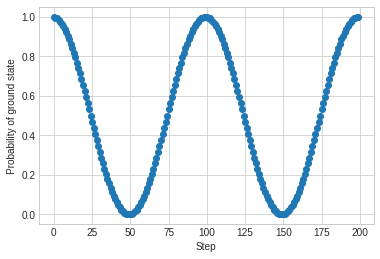

In [27]:
"""Plot the probability of measuring a qubit in the ground state."""
# Get a qubit.
a = cirq.NamedQubit('a')

# Get a circuit of a bunch of X rotations.
circuit = cirq.Circuit([cirq.rx(np.pi / 50.0)(a) for theta in range(200)])

# List to store probabilities of the ground state.
probs = []

# Step through the simulation results.
for step in simulator.simulate_moment_steps(circuit):
    prob = np.abs(step.state_vector()) ** 2
    probs.append(prob[0])

# Plot the probability of the ground state at each simulation step.
plt.style.use('seaborn-whitegrid')
plt.plot(probs, 'o')
plt.xlabel("Step")
plt.ylabel("Probability of ground state");

Above we have given ourselves direct access to the wave function and calculated the exact probabilities.  Suppose we wanted to sample from the wave function at each point instead.  

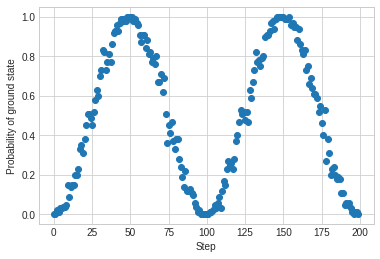

In [28]:
"""Plot the probability of measuring a qubit in the ground state by sampling."""
# Number of times to sample.
repetitions = 100

# List to store the probability of the ground state.
sampled_probs = []

for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    samples = step.sample([a], repetitions=repetitions)
    prob = np.sum(samples, axis=0)[0] / repetitions
    sampled_probs.append(prob)
    

# Plot the probability of the ground state at each simulation step.
plt.style.use('seaborn-whitegrid')
plt.plot(sampled_probs, 'o')
plt.xlabel("Step")
plt.ylabel("Probability of ground state");

## Custom gates

Supose there is a gate that you want Cirq to support, but it is not implemented in Cirq.  How do you go about adding a new gate?  

Cirq tries to be Pythonic.  One way in which it does this is that it relies on Python's **protocol** pattern.  Protocols are similar to interfaces, in that they define a collection of methods that an object must support to implement a protocol, but different in that this requirement is more informal and not a part of a class or interface declaration.  An object supports a protocol if it implements the methods that the protocol defines.  You're probably familiar with this if you've ever done something like defined your own `Container` in Python.  To do this for an object you simply define the `__contains__`, `__setitem__`, and `__getitem__` methods on your object, and then you can use this object anywere the Container protocol is supported.  

Let's see how this works for defining a custom gate.  The gate we will define is a single qubit gate that has only rational amplitudes. This is based on the famous 3, 4, 5 triangle you may remember from a long ago math class: $3^2 + 4^2 = 5^2$.  Using this observation we can construct normalized vectors and a unitary transform using the ratios of $3$, $4$, and $5$: 
$$
\zeta =\left[ \begin{array}
~\frac{3}{5} & \frac{4}{5} \\
-\frac{4}{5} & \frac{3}{5}
\end{array} \right]
$$

Below is a simple implementation of this gate in Cirq.  To do this we simply define a class that inherits from `cirq.SingleQubitGate` and implements the `cirq.SupportsUnitary` protocol by implementing the `_unitary_(self)` method.  We also define an optional `__str__` representation which Cirq will use when printing this gate out in a circuit diagram.

In [29]:
"""Example of defining a custom gate in Cirq."""
class RationalGate(cirq.SingleQubitGate):
    
    def _unitary_(self):
        return np.array([[3 / 5, 4 / 5], [-4 / 5, 3 / 5]])
    
    def __str__(self):
        return 'ζ'

We can now use this custom gate just like any other gate in Cirq.

In [30]:
"""Using the custom gate in a circuit."""
a = cirq.NamedQubit('a')
rg = RationalGate()
print(cirq.Circuit(rg(a)))

a: ───ζ───


We can also get its unitary, as shown below, because the `RationalGate` defines a `_unitary_` method.

In [31]:
print(cirq.unitary(rg))

[[ 0.6  0.8]
 [-0.8  0.6]]


Let's check that we can use this gate in a simulation.

In [32]:
"""Simulate a circuit with a custom gate."""
circuit = cirq.Circuit(rg(a))
simulator = cirq.Simulator()
result = simulator.simulate(circuit)
print(result.final_state_vector)

[ 0.6+0.j -0.8+0.j]


> *Note on simulating circuits with custom gates.* The `_unitary_` method is extremely inefficient for gates over many qubits. In most cases the method `_apply_unitary_` will be used instead, if it is available.
This method allows much more fine grained control on how a unitary is applied to a state, but it is harder to implement, for example because it is expected to use the pre-allocated workspace buffer that was given to it.
Almost all of the basic gates we have defined in Cirq have this method implemented. If you need to get performant, custom multi-qubit gates, you should implement a custom `_apply_unitary_` method for such gates.

### Exercise: Custom Controlled Rx gate

Recall that the `cirq.rx` gate is a rotation about the $X$ Pauli axis:
$$ 
{\tt cirq.rx(θ)}: \exp(-i \theta X) = cos \theta I - i \sin \theta X =\left[ \begin{array} ~\cos \theta & -i \sin \theta \\ -i \sin \theta & \cos \theta\end{array} \right] . \\
$$ 

As an exercise, create a two-qubit controlled `cirq.rx` gate defined as follows:
$$
{\tt CRx(\theta)}:
\left[\begin{array}
~1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0  \\
0 & 0 & \cos \theta & -i \sin \theta \\
0 & 0 & -i \sin \theta & \cos \theta
\end{array} \right] .
$$

In [33]:
"""Define a custom controlled cirq.rx gate here."""
class CRx(cirq.TwoQubitGate):
    def __init__(self, theta):
        self.theta = theta

    def _unitary_(self):
        return np.array([
            # Your code here!
        ])


# Print out its unitary.
print(np.around(cirq.unitary(CRx(0.25 * np.pi))))     

[]


#### Solution

In [34]:
"""Defining a custom controlled cirq.rx gate."""
class CRx(cirq.TwoQubitGate):
    def __init__(self, theta):
        self.theta = theta

    def _unitary_(self):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, np.cos(self.theta), -1j * np.sin(self.theta)],
            [0, 0, -1j * np.sin(self.theta), np.cos(self.theta)]
        ])
    
    def _circuit_diagram_info_(self, args):
        return '@', 'rx({}π)'.format(self.theta / np.pi)


# Print out its unitary.
print(np.around(cirq.unitary(CRx(0.25 * np.pi))))    

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.-1.j 1.+0.j]]


Note that we also define the `_circuit_diagram_info_` method which tells Cirq how to display the gate in a circuit diagram. The first string in the tuple is the symbol for the top wire, and the second string in the tuple is the symbol for the bottom wire. We can use this in a circuit to see the diagram info as shown below.

In [35]:
"""Display a circuit with the custom gate."""
# Get qubits.
a = cirq.NamedQubit('a')
b = cirq.NamedQubit('b')

# Display the circuit.
print('Circuit diagram:')
print(cirq.Circuit(CRx(0.25 * np.pi)(a, b)))

Circuit diagram:
a: ───@───────────
      │
b: ───rx(0.25π)───


### Gate decompositions

In many contexts, the notion of what gate you can apply is defined either by the physical hardware you are running or perhaps by the quantum error correcting code you are working with.  In quantum computing we typically talk about **gate sets** and work with respect to a given gate set.  Cirq supports gate decomposition via the `decompose` protocol.  Below we show how one can construct a gate that can be decomposed into two gates.

In [36]:
"""Example of a custom gate which supports the decompose protocol."""
class HXGate(cirq.SingleQubitGate):
    
    def _decompose_(self, qubits):
        return cirq.H(*qubits), cirq.X(*qubits)
    
    def __str__(self):
        return 'HX'

We can use this gate in a circuit as follows.

In [37]:
"""Use the gate in a circuit."""
HX = HXGate()

a = cirq.NamedQubit('a')
circuit = cirq.Circuit(HX(a))
print(circuit)

a: ───HX───


The symbol `HX` is a single gate, not a product of two gates. We can decompose the `HXGate` using `cirq.decompose` as shown below.

In [38]:
"""Decompose the gate."""
print(cirq.Circuit(cirq.decompose(circuit)))

a: ───Y^0.5───X───X───


Note that this not only decomposed the `HX` gate into `H` and `X`, it also decomposed `H` into `Y**0.5` and `X`.  In order to decompose only once, one can use `cirq.decompose_once`:

In [39]:
"""Decompose the gate once."""
print(cirq.Circuit(cirq.decompose_once(HX(a))))

a: ───H───X───


When we define a gate, it is good practice to give a default decomposition in terms of common gates.  However, often you will want to change this decomposition at run time for the specific hardware or context you are working in.  To do this we can define an interceptor function which does this decomposition before falling back to the default.

In [40]:
"""Define a custom decomposer."""
def my_decompose(op):
    if isinstance(op, cirq.GateOperation) and isinstance(op.gate, HXGate):
        return cirq.Z(*op.qubits), cirq.H(*op.qubits)

# Decompose the circuit according to this custom decomposer.
cirq.Circuit(cirq.decompose(HX(a), intercepting_decomposer=my_decompose))

a: ───Z───Y^0.5───X───

You can also define a predicate that says which gates to keep without decomposing further. This predicate should return `True` for all gates that should not be decomposed further, and `False` for all gates that should be decomposed further.

> The default predicate is to only keep gates that cannot be decomposed.

In [41]:
"""Define a predicate of which gates to keep without decomposing."""
def keep_h_and_x(op):
    return isinstance(op, cirq.GateOperation) and op.gate in [cirq.H, cirq.X]


# Decompose the HXGate using a custom predicate for which gates to not decompose.
print(cirq.decompose(HX(a), keep=keep_h_and_x))

[cirq.H(cirq.NamedQubit('a')), cirq.X(cirq.NamedQubit('a'))]


In this case, we see that neither `H` nor `X` have been decomposed, as we have specified in `keep_h_and_x`.

## Parameterized Circuits

In addition to circuit gates with fixed values, Cirq also supports parameterized gates with symbolic values via `sympy`. These are placeholder values, such as `sympy.Symbol('x')`, that will only be resolved at *run-time*. For simulators these values are resolved by providing a `ParamResolver`.  A `ParamResolver` provides a map from the `Symbol`'s name to its assigned value.  

> Plain Python dictionaries can also be used whenever a `ParamResolver` is needed.

In [42]:
"""Define a circuit with parameterized gates."""
# Import sympy for parameterized values.
import sympy as sp

# Get qubits to use in the circuit.
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

# Define a parameterized value.
val = sp.Symbol("s")

# Create a circuit.
circuit = cirq.Circuit(cirq.X.on(a) ** val, cirq.X.on(b) ** val)

# Display it.
print("Circuit with parameterized gates:\n")
print(circuit)

Circuit with parameterized gates:

a: ───X^s───

b: ───X^s───


When we simulate this circuit, we must provide a `param_resolver` as mentioned.

In [43]:
"""Simulate the circuit at multiple parameter values."""
simulator = cirq.Simulator()

# Simulate the circuit for several values of the parameter.
for y in range(5):
    result = simulator.simulate(circuit, param_resolver={"s": y / 4.0})
    print("s={}: {}\n".format(y, np.around(result.final_state_vector, 2)))

s=0: [1.+0.j 0.+0.j 0.+0.j 0.+0.j]

s=1: [ 0.6 +0.6j   0.25-0.25j  0.25-0.25j -0.1 -0.1j ]

s=2: [0. +0.5j 0.5+0.j  0.5+0.j  0. -0.5j]

s=3: [-0.1 +0.1j   0.25+0.25j  0.25+0.25j  0.6 -0.6j ]

s=4: [0.+0.j 0.+0.j 0.+0.j 1.+0.j]



Here we see that the `Symbol` is used in two gates, and then the resolver provides this value at run time.

Parameterized values are most useful in defining what we call a `Study`.  A `Study` is a collection of trials, where each  trial is a run with a particular set of configurations and which may be run repeatedly.  Running a study returns a list of `TrialResult`s per set of fixed parameter values and repetitions.  Example:


In [44]:
"""Simulate the circuit at multiple parameter values."""
# Get a list of param resolvers.
resolvers = [cirq.ParamResolver({'s': y / 8.0}) for y in range(5)]

# Add measurements to the circuit.
circuit.append([cirq.measure(a), cirq.measure(b)])

# Simulate the circuit using run_sweep.
results = simulator.run_sweep(
    program=circuit,
    params=resolvers,
    repetitions=10
)

for i, result in enumerate(results):
    print('params: {}\n{}\n'.format(result.params.param_dict, result))

params: OrderedDict([('s', 0.0)])
a=0000000000
b=0000000000

params: OrderedDict([('s', 0.125)])
a=0000000000
b=0000000000

params: OrderedDict([('s', 0.25)])
a=0000000000
b=1001000000

params: OrderedDict([('s', 0.375)])
a=1110101001
b=0001000100

params: OrderedDict([('s', 0.5)])
a=0000010011
b=0100111101



Above we passed in a list of `ParamResolver`s to the `params` parameter of `run_sweep`.  But one can also pass in a `Sweepable`.  There are some useful methods for generating `Sweepable`s, for example to generate an equally spaced set of param resolvers one can use `Linspace`


In [45]:
"""Alternative method of getting a sequence of param resolvers."""
linspace = cirq.Linspace(start=0, stop=1.0, length=11, key='x')
for p in linspace:
    print(p)

cirq.ParamResolver({'x': 0.0})
cirq.ParamResolver({'x': 0.1})
cirq.ParamResolver({'x': 0.2})
cirq.ParamResolver({'x': 0.3})
cirq.ParamResolver({'x': 0.4})
cirq.ParamResolver({'x': 0.5})
cirq.ParamResolver({'x': 0.6})
cirq.ParamResolver({'x': 0.7})
cirq.ParamResolver({'x': 0.8})
cirq.ParamResolver({'x': 0.9})
cirq.ParamResolver({'x': 1.0})


### Exercise: Rotate a qubit

Let's do the equivalent of a Rabi-flop experiment.  That is, let's apply a `XPowGate` rotating about the `X` axis for a linearly spaced set of values followed by a computational basis measurement.  The end result should be a plot of the sampled fraction that were $|1\rangle$ as a function of gates of $X^t$ for $t$ between 0 and $1$ for 100 values of $t$ and each result sampled 100 times.

In [46]:
# Your code here!


## Noise

In addition to circuits with unitary gates, Cirq also has support for modeling noisy quantum evolutions. This is useful when modeling what will happen when running on actual hardware.

Cirq currently supports noise that fits within the context of *operator sum representations* of noise (a.k.a quantum operations, quantum dyanamical maps, superoperators, etc).  This formalism models the evolution of a density matrix via 

$$ 
\rho \rightarrow \sum_k A_k \rho A_k^\dagger 
$$

where the $A_k$ are *Kraus operators*.  These operators are not necessarily unitary and satisfy the property

$$ 
\sum_k A_k^\dagger A_k = I . 
$$

An example of a noise operator is the depolarizing channel on one qubit.  This takes

$$
\rho \rightarrow (1-p) \rho + \frac{p}{3} (X \rho X + Y \rho Y + Z \rho Z) .
$$

In Cirq we can define such a channel and use it in a quantum circuit:

In [47]:
"""Create a circuit with a depolarizing channel."""
circuit = cirq.Circuit(cirq.depolarize(0.2)(a), cirq.measure(a))
print(circuit)

a: ───D(0.2)───M───


Previously we saw that gates could implement that `_unitary_` protocol, and by doing so they could be used to perform wave function simulation.  For noise the gates implement the `_channel_` protocol.  Classes that implement this protocol return the Krauss operators on their `_channel_` method.  Thus

In [48]:
for i, kraus in enumerate(cirq.channel(cirq.depolarize(0.2))):
    print(f"Kraus operator {i} is:", kraus, sep="\n", end="\n\n")

Kraus operator 0 is:
[[0.89442719 0.        ]
 [0.         0.89442719]]

Kraus operator 1 is:
[[0.        +0.j 0.25819889+0.j]
 [0.25819889+0.j 0.        +0.j]]

Kraus operator 2 is:
[[0.+0.j         0.-0.25819889j]
 [0.+0.25819889j 0.+0.j        ]]

Kraus operator 3 is:
[[ 0.25819889+0.j  0.        +0.j]
 [ 0.        +0.j -0.25819889+0.j]]



The Kraus operators are often more conveniently represented in a Pauli basis. We can do this in Cirq as shown below.

In [49]:
for i, krauss in enumerate(cirq.channel(cirq.depolarize(0.2))):
    pauli_ex = cirq.expand_matrix_in_orthogonal_basis(krauss, cirq.PAULI_BASIS)
    print(f"Kraus operator {i} is:", pauli_ex, sep="\n", end="\n\n")

Kraus operator 0 is:
0.894*I

Kraus operator 1 is:
0.258*X

Kraus operator 2 is:
0.258*Y

Kraus operator 3 is:
0.258*Z



In addition to the wavefunction simulator, Cirq also has a density matrix simulator.  Instead of keeping track of the wavefunction, this simulator keeps track of the density matrix.  It has the same `run` and `simulate` type methods.  For example we can use this to simulate depolarizing channel and return the final density matrix of the system.

In [50]:
"""Example of simulating a noisy circuit with the density matrix simulator."""
# Circuit to simulate.
circuit = cirq.Circuit(cirq.depolarize(0.2)(a))
print('Circuit:\n{}\n'.format(circuit))

# Get the density matrix simulator.
simulator = cirq.DensityMatrixSimulator()

# Simulate the circuit and get the final density matrix.
matrix = simulator.simulate(circuit).final_density_matrix
print('Final density matrix:\n{}'.format(matrix))

Circuit:
a: ───D(0.2)───

Final density matrix:
[[0.8666666 +0.j 0.        +0.j]
 [0.        +0.j 0.13333333+0.j]]


One thing to note is that the density matrix simulator simulates measurement statistically, and not as a channel where the outcome is not known. Consider the following example.

In [51]:
"""Simulating a circuit with measurements using the DensityMatrixSimulator."""
# Get a circuit with measurements.
circuit = cirq.Circuit(cirq.depolarize(0.5)(a), cirq.measure(a))

# Simulate with the density matrix multiple times.
dmat1 = simulator.simulate(circuit).final_density_matrix
dmat2 = simulator.simulate(circuit).final_density_matrix

print(np.allclose(dmat1, dmat2))

False


Because the final density matrix is statistical due to the measurements, the output of the above cell will change when executed multiple times.

### Monte carlo simulations

Density matrix simulations are more expensive than pure state wave function simulations.  However some channels allow an interpreation of randomly applying one of a fixed set of unitaries with differing probabilites.  For example the depolarizing channel above can be interpretted as: 

- With probability $1-p$ apply the identity to the state, and
- with probability $p$ apply one of the three Pauli matrices $X$, $Y$, or $Z$ with equal probability.

Channels that can be interpretted in this form can be simulating using a wavefunction simulator: when this channel is simulated the simulation will sample a unitary with the appropriate probability.  

For channels of these type, the channel can, instead of implementing the `_channel_` protocol, implement the `_mixture_` protocol:

In [52]:
"""Use the cirq.mixture protocol on the cirq.depolarize channel."""
for p, u in cirq.mixture(cirq.depolarize(0.2)):
    print("prob = {}\nunitary: \n{}\n".format(p, u))

prob = 0.8
unitary: 
[[1. 0.]
 [0. 1.]]

prob = 0.06666666666666667
unitary: 
[[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]

prob = 0.06666666666666667
unitary: 
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

prob = 0.06666666666666667
unitary: 
[[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]



In fact the depolarizing channel does not implement `_channel_`.  Instead it only implements `_mixture_` and the `cirq.channel` method notices this and derives the channel from the mixture.

In [53]:
"""Check if cirq.depolarize has _channel_ and _mixture_ methods."""
# Get a depolarizing channel.
d = cirq.depolarize(0.2)

# Check if it has _channel_ implemented.
print('does cirq.depolarize(0.2) have _channel_? {}'.format('yes' if getattr(d, '_channel_', None) else 'no'))

# Check if it has _mixture_ implemented.
print('does cirq.depolarize(0.2) have _mixture_? {}'.format('yes' if getattr(d, '_mixture_', None) else 'no'))

does cirq.depolarize(0.2) have _channel_? no
does cirq.depolarize(0.2) have _mixture_? yes


When channels implement mixture then, as we said, we can use the wavefunction simulator:

In [54]:
"""Use the wavefunction simulator on a channel that implements the mixture protocol."""
circuit = cirq.Circuit(cirq.depolarize(0.5).on(a), cirq.measure(a))
simulator = cirq.Simulator()
result = simulator.run(circuit, repetitions=10)
print(result)

a=0000000110


Because the unitary Kraus operators are applied stochastically, executing the above cell multiple times will produce different outputs.

### Adding noise to circuits and simulations

To add noise to circuits or during simulations, we provide the notion of a `NoiseModel`.  A `NoiseModel` may add noise operation by operation, or it may add noise moment by moment, or it may add noise across a list of moments.

For example we can define a noise model that add a single qubit depolarizing for every qubit in each moment.  

In [55]:
"""Adding noise to a circuit."""
# Get a noiseless circuit.
noise = cirq.ConstantQubitNoiseModel(cirq.depolarize(0.2))
circuit = cirq.Circuit(cirq.H(a), cirq.CNOT(a, b), cirq.measure(a, b))
print('Circuit with no noise:\n{}\n'.format(circuit))

# Add noise to the circuit.
system_qubits = sorted(circuit.all_qubits())
noisy_circuit = cirq.Circuit()
for moment in circuit:
    noisy_circuit.append(noise.noisy_moment(moment, system_qubits))
print('Circuit with noise:\n{}'.format(noisy_circuit))

Circuit with no noise:
a: ───H───@───M───
          │   │
b: ───────X───M───

Circuit with noise:
a: ───H───D(0.2)[cirq.VirtualTag()]───@───D(0.2)[cirq.VirtualTag()]───M───D(0.2)[cirq.VirtualTag()]───
                                      │                               │
b: ───────D(0.2)[cirq.VirtualTag()]───X───D(0.2)[cirq.VirtualTag()]───M───D(0.2)[cirq.VirtualTag()]───


We can also pass a noise model into the `cirq.DensityMatrixSimulator` and execute a noisy circuit in this manner.

In [56]:
"""Perform noisy simulation by defining a density matrix simulator with a noise model."""
# Define a noise model.
noise = cirq.ConstantQubitNoiseModel(cirq.depolarize(0.2))

# Pass this noise model into the simulator.
simulator = cirq.DensityMatrixSimulator(noise=noise)

# Get a circuit to simulate.
circuit = cirq.Circuit(cirq.H(a), cirq.CNOT(a, b), cirq.measure(a, b))

# Simulate the circuit in steps.
for i, step in enumerate(simulator.simulate_moment_steps(circuit)):
    print('After step {} state was\n{}\n'.format(i, step.density_matrix()))

After step 0 state was
[[0.4333333 +0.j 0.        +0.j 0.31777775+0.j 0.        +0.j]
 [0.        +0.j 0.06666666+0.j 0.        +0.j 0.04888888+0.j]
 [0.31777775+0.j 0.        +0.j 0.4333333 +0.j 0.        +0.j]
 [0.        +0.j 0.04888888+0.j 0.        +0.j 0.06666666+0.j]]

After step 1 state was
[[0.34859255+0.j 0.        +0.j 0.        +0.j 0.17089382+0.j]
 [0.        +0.j 0.15140739+0.j 0.02629136+0.j 0.        +0.j]
 [0.        +0.j 0.02629136+0.j 0.15140739+0.j 0.        +0.j]
 [0.17089382+0.j 0.        +0.j 0.        +0.j 0.34859255+0.j]]

After step 2 state was
[[0.75111103+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.11555554+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.11555553+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.01777777+0.j]]



## Devices

NISQ algorithms work in a regime where every gate counts.  A key philosophy behind Cirq is that we believe the details of the hardware, the performance characteristics, as well as device constraints, will be key to getting the most out of NISQ algorithms.  Towards this end these hardware features are contained in the `Device` class.

For example, here is Google's Bristleconde device which we printed out at the start of this notebook.

In [57]:
print(cirq.google.Bristlecone)

                                             (0, 5)────(0, 6)
                                             │         │
                                             │         │
                                    (1, 4)───(1, 5)────(1, 6)────(1, 7)
                                    │        │         │         │
                                    │        │         │         │
                           (2, 3)───(2, 4)───(2, 5)────(2, 6)────(2, 7)───(2, 8)
                           │        │        │         │         │        │
                           │        │        │         │         │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)────(3, 6)────(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │         │         │        │        │
                  │        │        │        │         │         │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)────(4, 6)────(4, 7)───(4, 8)───(4, 9)───(4, 10)
         │        │      

In a future version, we intend for each `Device` to define a noise model.

`Device`s also contain more information about the timing of the device.  For example here we can calculate the duration of an `X` on the `Bristlecone` device.

In [58]:
"""Get the duration of an operation."""
brissy = cirq.google.Bristlecone
op = cirq.X.on(cirq.GridQubit(5, 5))
print(brissy.duration_of(op))

20 ns


Another property of devices is that they can be used to enforce constraints from the hardware, both checking that these constraints are satisfied, but also enforcing the constraints on the device.  For example, on the `Bristlecone` device, a two-qubit gate has the property that one cannot simultaneously perform a pair of two-qubit gates that act on adjacent qubits. So for example if we create such a `Circuit` and validate it using the device, we will see an error.

In [59]:
"""Validate operations on a device."""
# Get adjacent qubits on the Bristlecone device.
q55 = cirq.GridQubit(5, 5)
q56 = cirq.GridQubit(5, 6)
q66 = cirq.GridQubit(6, 6)
q67 = cirq.GridQubit(6, 7)

# Define operations on adjacent qubits.
ops = [cirq.CZ(q55, q56), cirq.CZ(q66, q67)]
circuit = cirq.Circuit(ops)
print(circuit)

# cirq.google.Bristlecone.validate_circuit(circuit)
# (this should throw an error)

(5, 5): ───@───
           │
(5, 6): ───@───

(6, 6): ───@───
           │
(6, 7): ───@───


But more interestingly we could have passed the device into the `Circuit` and it will perform the creation of the circuit (using the insertion semantics as described above) such that the device cannot violate the constraints.

In [60]:
"""Create a circuit for a particular device."""
# Same adjacent operations as above.
ops = [cirq.CZ(q55, q56), cirq.CZ(q66, q67)]

# Create a circuit on the Bristlecone device.
circuit = cirq.Circuit(device=cirq.google.Bristlecone)


# When we append operations now, they are put into different moments.
circuit.append(ops)
print(circuit)

(5, 5): ───@───────
           │
(5, 6): ───@───────

(6, 6): ───────@───
               │
(6, 7): ───────@───


### Exercise: Make a Device

Construct a device that acts on a square sized lattice, and only allows Hadamard, CZ, and measurement gates.

In [61]:
# Your code here!

## Compiling / Optimizing

Cirq's philosophy for what are often called compilation steps is slightly non-traditional.  In particular we believe that NISQ devices perform so few gates that many compiliations will be one or a few passes. A useful class of optimization code for this is the `PointOptimizer`. For example, here is a `PointOptimizer` that recognizes that a `X` gate followed by a `Z` gate is equivalent to a `Y` gate

In [62]:
"""Example of defining a custom cirq.PointOptimizer."""
class XZOptimizer(cirq.PointOptimizer):
    """Replaces an X followed by a Z with a Y."""
    
    def optimization_at(self, circuit, index, op):
        # Is the gate an X gate?
        if isinstance(op, cirq.GateOperation) and (op.gate == cirq.X):
            next_op_index = circuit.next_moment_operating_on(op.qubits, index + 1)
            qubit = op.qubits[0]
            if next_op_index is not None:
                next_op = circuit.operation_at(qubit, next_op_index)
                if isinstance(next_op, cirq.GateOperation) and  (next_op.gate == cirq.Z):
                    new_op = cirq.Y.on(qubit)
                    return cirq.PointOptimizationSummary(
                        clear_span = next_op_index - index + 1,
                        clear_qubits=op.qubits, 
                        new_operations=[new_op])
        
opt = XZOptimizer()
circuit = cirq.Circuit(cirq.X(a), cirq.Z(a), cirq.CZ(a, b), cirq.X(a))
print("Before optimizing:\n{}\n". format(circuit))
opt.optimize_circuit(circuit)
print("After optimizing:\n{}".format(circuit))

Before optimizing:
a: ───X───Z───@───X───
              │
b: ───────────@───────

After optimizing:
a: ───Y───────@───X───
              │
b: ───────────@───────


### Exercise: Simplify flipped CNOTs

Write an PointOptimizer that performs (greedily) the simplification that

```
a: ───H───@───H───
          │
b: ───H───X───H───
```
is equal to


```
a: ───X───
      │
b: ───@───
```


In [63]:
# Your code here!

In [64]:
"""Test your optimizer on this circuit."""
circuit = cirq.Circuit(
    cirq.H.on_each(a, b, c), 
    cirq.CNOT(a, b), 
    cirq.H.on_each(a, b), 
    cirq.CZ(a, b)
)
# Instantiate your optimizer
# my_opt = 

# And check that it worked.
# print(my_opt.optimizer_circuit(circuit))

## Google's Xmon Gates

We built Cirq at Google because we thought that it was important that hardware details flow up through the level of abstractions in a framework for NISQ algorithms.  And we also built it because Google has a class of superconducting qubit devices where we want to explore NISQ algorithms.  

What sort of gates does the xmon architecture support?  At the hardware level the basic gate set is rotations about the Pauli $Z$ axis

$$
\exp(-iZt) = \left[ 
\begin{matrix}
 e^{it} & 0 \\
 0 & e^{-it}
\end{matrix}
\right]
$$

Rotations about any axis in the Pauli $X$ and $Y$ plane:

$$
\exp(-i(\cos \theta X + \sin \theta Y) t) = 
\left[
\begin{matrix}
\cos t & -i\sin t e^{-i \theta} \\
-i\sin t e^{i \theta} & \cos t
\end{matrix}
\right]
$$

The two qubit gate is a phase about the $|11\rangle$ state:

$$
\exp(-it |11\rangle \langle 11|) =
\left[ 
\begin{matrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & \exp(-it)
\end{matrix}
\right]
$$

And finally measurements in the computational basis.

Many of the common gates in Cirq are directly accessible on this hardware.  To check whether the gate you are using is in the xmon gate set, one can use the `is_supported_operation` as shown below.

In [65]:
"""Check if an operation is supported by the XMON gate set."""
# Get the XMON gate set.
xmon = cirq.google.gate_sets.XMON

# Check if X is supported.
xmon.is_supported_operation(cirq.X.on(cirq.NamedQubit("a")))

True

Thus, `cirq.X` is supported by the xmon gate set. As mentioned above, `cirq.CNOT` is not supported, so the following code block should return `False`.

In [66]:
"""Check if CNOT is supported."""
xmon.is_supported_operation(cirq.CNOT.on(cirq.NamedQubit('a'), cirq.NamedQubit('b')))

False

When a gate is not a native xmon gate, Cirq can often convert it to an xmon native gate.

In [67]:
"""Convert a gate to xmon gates."""
# Get a converter.
converter = cirq.google.ConvertToXmonGates()

# Do the conversion.
converted = converter.convert(cirq.CNOT.on(cirq.NamedQubit("a"), cirq.NamedQubit("b")))
print(cirq.Circuit(converted))

a: ───Z^0.75────X^0.5────S^-1───Y^-0.5───@───S^-1───Y^0.5───Y^0.5─────Z^-0.75───
                                         │
b: ───X^-0.25───Y^-0.5───────────────────@───S^-1───Y^0.5───X^-0.25─────────────


This isn't very optimized because what it has done is first rely on the decompose of `CNOT` and then decomposed each of these into native xmon gates.  There are many tricks that one can use to simplify xmon gates.  To apply many of these one can use the `cirq.google.optimize_from_xmon` method:

In [68]:
"""Optimize a circuit for the xmon gate set."""
circuit = cirq.Circuit(
    cirq.CNOT.on(cirq.NamedQubit("a"), cirq.NamedQubit("b"))
)
print(cirq.google.optimized_for_xmon(circuit))

a: ───PhXZ(a=0.375,x=1,z=0)────@───PhXZ(a=-0.625,x=1,z=0)────
                               │
b: ───PhXZ(a=-0.5,x=0.5,z=0)───@───PhXZ(a=-0.5,x=0.5,z=-1)───


Because xmon gates can be executed on Google hardware, they will need to be transmitted as machine code to the quantum computer.  This means that they have a serialized form.  We use protobuffers as the serialization.  To see what this form looks like we can do the following.

In [69]:
"""Serialize an operation."""
xmon.serialize_op(cirq.X.on(cirq.GridQubit(5, 5)))

gate {
  id: "xy"
}
args {
  key: "axis_half_turns"
  value {
    arg_value {
      float_value: 0.0
    }
  }
}
args {
  key: "half_turns"
  value {
    arg_value {
      float_value: 1.0
    }
  }
}
qubits {
  id: "5_5"
}

## Other interesting things in Cirq

**Experiments**. The `cirq.experiments` package can perform and plot the results of some basic experiments for understanding how well a system is performing.


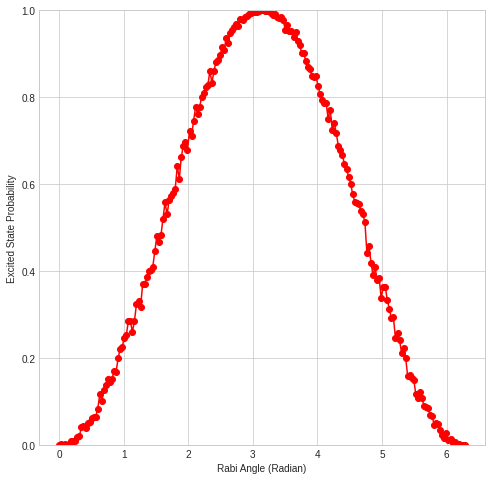

In [70]:
result = cirq.experiments.rabi_oscillations(
    sampler=cirq.Simulator(),  # In the future, sampler could point at real hardware.
    qubit=cirq.LineQubit(0)
)
result.plot();

**Testing**. The `cirq.testing` package has useful debugging and testing methods like `cirq.testing.assert_implements_consistent_protocols` and `cirq.testing.assert_allclose_up_to_global_phase`.


In [71]:
class InconsistentXGate(cirq.SingleQubitGate):

    def _decompose_(self, qubits):
        yield cirq.H(qubits[0])
        yield cirq.Z(qubits[0])
        yield cirq.H(qubits[0])

    def _unitary_(self):
        return np.array([[0, -1j], [1j, 0]])  # Oops! Y instead of X!

# cirq.testing.assert_decompose_is_consistent_with_unitary(InconsistentXGate())

**Export**. You can export a circuit as Qasm.

In [72]:
"""Export a circuit to Qasm."""
a, b, c = cirq.LineQubit.range(3)
circuit = cirq.Circuit(cirq.H(a), cirq.H(c), cirq.CNOT(a, b), cirq.CCZ(a, b, c))
print(circuit.to_qasm())

// Generated from Cirq v0.9.1

OPENQASM 2.0;
include "qelib1.inc";


// Qubits: [0, 1, 2]
qreg q[3];


h q[0];
h q[2];
cx q[0],q[1];
h q[2];
ccx q[0],q[1],q[2];
h q[2];



You can also export a circuit as QUIL:

In [73]:
"""Export a circuit to QUIL."""
print(circuit.to_quil())

# Created using Cirq.

H 0
H 2
CNOT 0 1
H 2
CCNOT 0 1 2
H 2



You can also turn a circuit into a link to the drag-and-drop web simulation Quirk (though somewhat inconveniently).

In [74]:
"""Export a circuit to a Quirk URL."""
from cirq.contrib.quirk.export_to_quirk import circuit_to_quirk_url
print(circuit_to_quirk_url(circuit))

http://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C1%2C%22H%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22%E2%80%A2%22%2C%22%E2%80%A2%22%2C%22Z%22%5D%5D%7D
